In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import data
from hyperparameters import SimArgs
from parameters import weight_generation, weight_generation_r1
from jax.example_libraries import optimizers
# check gpu with jax
print(jax.devices())

[CpuDevice(id=0)]


I0000 00:00:1714494412.994093       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
# pip3 install notebook==7.0.4 pandas==2.1.1 torch==2.2.0 h5py==3.9.0 matplotlib==3.8.0 scikit-learn==1.3.1 jax==0.4.16 jaxlib==0.4.16

In [ ]:
!pip

In [3]:
n_in = 700
n_h = 256 # useless here
seed = 42
tau_mem = 20e-3
transition_steps = 1000
transition_begin = 1000
noise_injection_std = 0.1
nb_epochs = 15
args = SimArgs(n_in, n_h, seed, tau_mem, transition_steps, transition_begin, noise_injection_std, nb_epochs)
args.lr = 0.001

In [4]:
train_loader, val_loader, test_loader = data.get_data_loaders(args)
in_spikes_test_batch0, gt_labels_test_batch0 = next(iter(test_loader))
print(f'{in_spikes_test_batch0.shape=}, {gt_labels_test_batch0.shape=}')
print(f'We will vmap on the first dimension, so each thread will process one sample of size {in_spikes_test_batch0.shape[1:]}')
print(f'We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size {in_spikes_test_batch0.shape[2]}')

datasets:
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_train.h5
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_test.h5
in_spikes_test_batch0.shape=(64, 150, 700), gt_labels_test_batch0.shape=(64,)
We will vmap on the first dimension, so each thread will process one sample of size (150, 700)
We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size 700


In [5]:
@jax.custom_jvp
def gr_than(x, thr):
    """ Thresholding function for spiking neurons. """
    return (x > thr).astype(jnp.float32)


@gr_than.defjvp
def gr_jvp(primals, tangents):
    """ Surrogate gradient function for thresholding. """
    x, thr = primals
    x_dot, y_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
    return primal_out, tangent_out

def lif_forward(state, input_spikes):
    ''' Vectorized Leaky Integrate and Fire (LIF) neuron model
    '''
    w, (i, v, z) = state[0]
    tau_mem, v_th, timestep = state[1]
    i = jnp.dot(w, input_spikes)  # + jnp.dot(Wrec, S_h)
    v = (1 - timestep / tau_mem) * v + i - z * v_th
    v = jnp.maximum(0, v)
    z = gr_than(v, v_th)

    return ((w, (i, v, z)), state[1]), (i, v, z)    
    

In [62]:
def prediction(w, hp, in_spikes):
    i = jnp.zeros((w.shape[0],))
    v = jnp.zeros((w.shape[0],))
    z = jnp.zeros((w.shape[0],))
    state = ((w, (i, v, z)), hp) 
    _, (i, v, z) = jax.lax.scan(lif_forward, state, in_spikes)
    return i, v, z
    
prediction_jv = jax.jit(jax.vmap(prediction, in_axes=(None, None, 0)), static_argnums=(1,))


def loss_fn(w, hp, in_spikes, gt_labels):
    _, v, _ = prediction_jv(w, hp, in_spikes)
    out = jnp.max(v, axis=1)
    logit = jax.nn.softmax(out)
    loss = -jnp.mean(jnp.log(logit[jnp.arange(gt_labels.shape[0]), gt_labels]))
    
    pred = jnp.argmax(out, axis=1)
    acc = jnp.count_nonzero(pred == gt_labels) / gt_labels.shape[0]
    return loss, acc

def update(opt, hp, in_spikes, gt_labels, e):
    get_params, opt_state, opt_update = opt
    w = get_params(opt_state)
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(w, hp, in_spikes, gt_labels)
    opt_state = opt_update(e, grads, opt_state)
    return (loss, acc), (get_params, opt_state, opt_update)
    
def run_epoch(opt, hp, loader, e):
    epoch_loss = jnp.zeros((len(loader)))
    epoch_acc = jnp.zeros((len(loader)))
    for id_batch, (in_spikes, gt_labels) in enumerate(loader):
        (loss, acc), opt = update(opt, hp, in_spikes, gt_labels, e)
        epoch_loss = epoch_loss.at[id_batch].set(loss)
        epoch_acc = epoch_acc.at[id_batch].set(acc)
    return (epoch_loss, epoch_acc), opt

def inference(w, hp, loader):
    inference_loss = np.zeros((len(loader)))
    inference_acc = np.zeros((len(loader)))
    full_label = []
    full_pred = []
    for id_batch, (in_spikes, gt_labels) in enumerate(loader): 
        _, v, _ = prediction_jv(w, hp, in_spikes)
        out = jnp.max(v, axis=1)
        logit = jax.nn.softmax(out)
        inference_loss[id_batch] = -jnp.mean(jnp.log(logit[jnp.arange(gt_labels.shape[0]), gt_labels]))
        
        pred = jnp.argmax(out, axis=1)
        inference_acc[id_batch] = jnp.count_nonzero(pred == gt_labels) / gt_labels.shape[0]
        full_label.append(gt_labels)
        full_pred.append(pred)
    full_label = np.concatenate(full_label, axis=0)
    full_pred = np.concatenate(full_pred, axis=0)

    return inference_loss, inference_acc, (full_label, full_pred)


def train(w, hp, train_loader, val_loader, test_loader):
    opt_init, opt_update, get_params = optimizers.adam(step_size=args.lr)
    opt_state = opt_init(w)
    print(f'{"Epoch":<6}|{"Loss":<10}|{"Acc":<10}|{"Val Acc":<10}|{"Test Acc":<10}|{"Val Loss":<10}|{"Test Loss":<10}')
    print(f'{"-"*6}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}')
    best_val_acc = 0.05 # Random guess
    test_loss = jnp.nan
    patience = 20
    best_opt_state = None
    hist_train_loss = np.zeros((args.nb_epochs))
    hist_val_loss = np.zeros((args.nb_epochs))
    hist_test_loss = np.zeros((args.nb_epochs))
    opt = (get_params, opt_state, opt_update)
    for e in range(args.nb_epochs):
        (epoch_loss, epoch_acc), opt = run_epoch(opt, hp, train_loader, e)
        _, opt_state, _ = opt
        val_loss, val_acc, _ = inference(get_params(opt_state), hp, val_loader)
        if val_acc.mean() > best_val_acc:
            best_val_acc = val_acc.mean()
            best_opt_state = opt_state
            patience = 20
            test_loss, test_acc, _ = inference(get_params(opt_state), hp, test_loader)
            print(f'{e:<6}|{epoch_loss.mean():<10.4f}|{epoch_acc.mean():<10.4f}|{val_acc.mean():<10.4f}|{test_acc.mean():<10.4f}|{val_loss.mean():<10.4f}|{test_loss.mean():<10.4f}')
        else:
            patience -= 1
            if e % 10 == 0:
                print(f'{e:<6}|{epoch_loss.mean():<10.4f}|{epoch_acc.mean():<10.4f}|{val_acc.mean():<10.4f}|{"-":<10}|{val_loss.mean():<10.4f}|{"-":<10}')  
            if patience == 0:
                break
        hist_train_loss[e] = epoch_loss.mean()
        hist_val_loss[e] = val_loss.mean()
        hist_test_loss[e] = test_loss.mean()

In [63]:
key = jax.random.PRNGKey(args.seed)
key, w = weight_generation(key, args, visualize_plot=False)
w_original = w
print(f'{w_original.shape=}')
hp = (args.tau_mem, args.v_thr, args.timestep)


w_original.shape=(20, 700)


In [64]:
get_params, opt_state = train(w, hp, train_loader, val_loader, test_loader)

Epoch |Loss      |Acc       |Val Acc   |Test Acc  |Val Loss  |Test Loss 
------|----------|----------|----------|----------|----------|----------
0     |2.5188    |0.2030    |0.2856    |0.3344    |2.1821    |2.1110    
1     |2.0846    |0.3267    |0.3175    |0.3420    |2.0737    |2.0505    
2     |1.9795    |0.3790    |0.3400    |0.3612    |2.0044    |2.0092    
4     |1.8687    |0.4363    |0.3506    |0.3594    |1.9693    |1.9833    
6     |1.8092    |0.4618    |0.3706    |0.3656    |1.9340    |1.9606    
10    |1.7285    |0.4930    |0.3725    |0.3701    |1.8951    |1.9381    
11    |1.7114    |0.5031    |0.3756    |0.3674    |1.8812    |1.9429    


In [65]:
i_original, v_original, z_original = prediction_jv(w_original, hp, in_spikes_test_batch0)
i, v, z = prediction_jv(get_params(opt_state), hp, in_spikes_test_batch0)
# i, v, z = prediction_jv(w, hp, in_spikes_test_batch0)

In [66]:
jnp.array_equal(i, i_original), jnp.array_equal(v, v_original), jnp.array_equal(z, z_original)

(Array(False, dtype=bool), Array(False, dtype=bool), Array(False, dtype=bool))

z0_pca.shape=(150, 2)


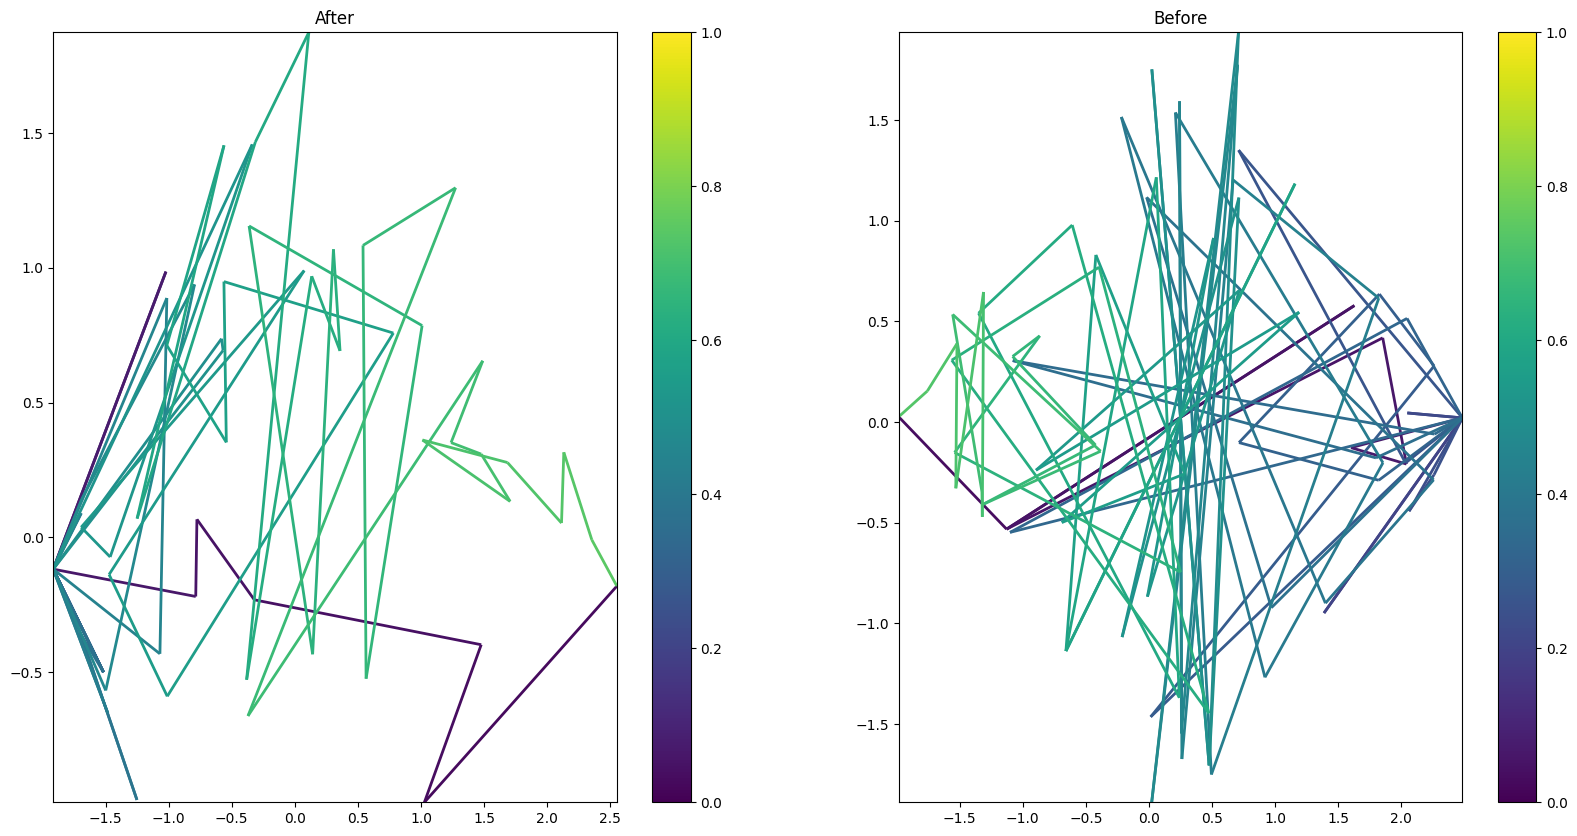

In [67]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
# compute the PCA of the output spikes
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

sample_id = 0
z0 = z[sample_id]
z0_original = z_original[sample_id]

z0_pca = pca.fit_transform(z0)
z0_original_pca = pca.fit_transform(z0_original)
print(f'{z0_pca.shape=}')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

t = np.arange(150)

data = [z0_pca, z0_original_pca]
for i in range(2):
    x    = data[i][:, 0]
    y    = data[i][:, 1]
    cols = np.linspace(0,1,len(x))

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap='viridis')
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = ax[i].add_collection(lc)
    # set x and y limits
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_ylim(y.min(), y.max())
    # colorbar
    fig.colorbar(line,ax=ax[i])
ax[0].set_title('After')
ax[1].set_title('Before')
plt.show()

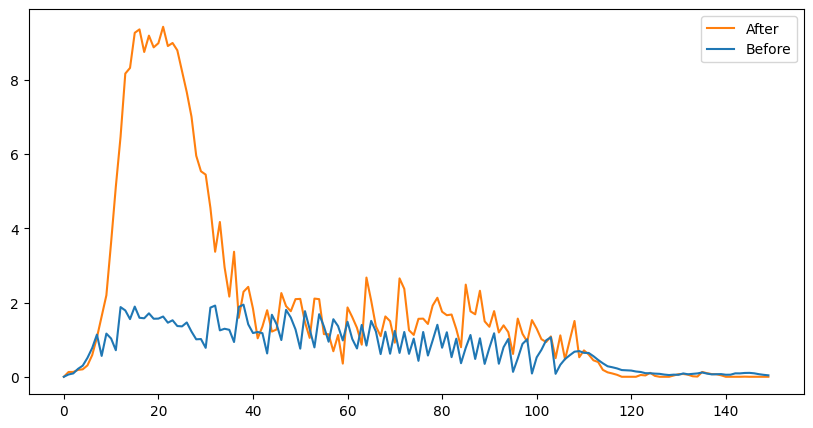

In [68]:
import matplotlib.pyplot as plt
sample_id = 0
v0 = v[sample_id]
v0_original = v_original[sample_id]
# plot the membrane potential of the 20 neurons with 150 timestep 
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
for i in range(20):
    if i == gt_labels_test_batch0[sample_id]:
        axs.plot(v0[:, i], label=f'After', color='C1')
        axs.plot(v0_original[:, i], label=f'Before', color='C0')
plt.legend()

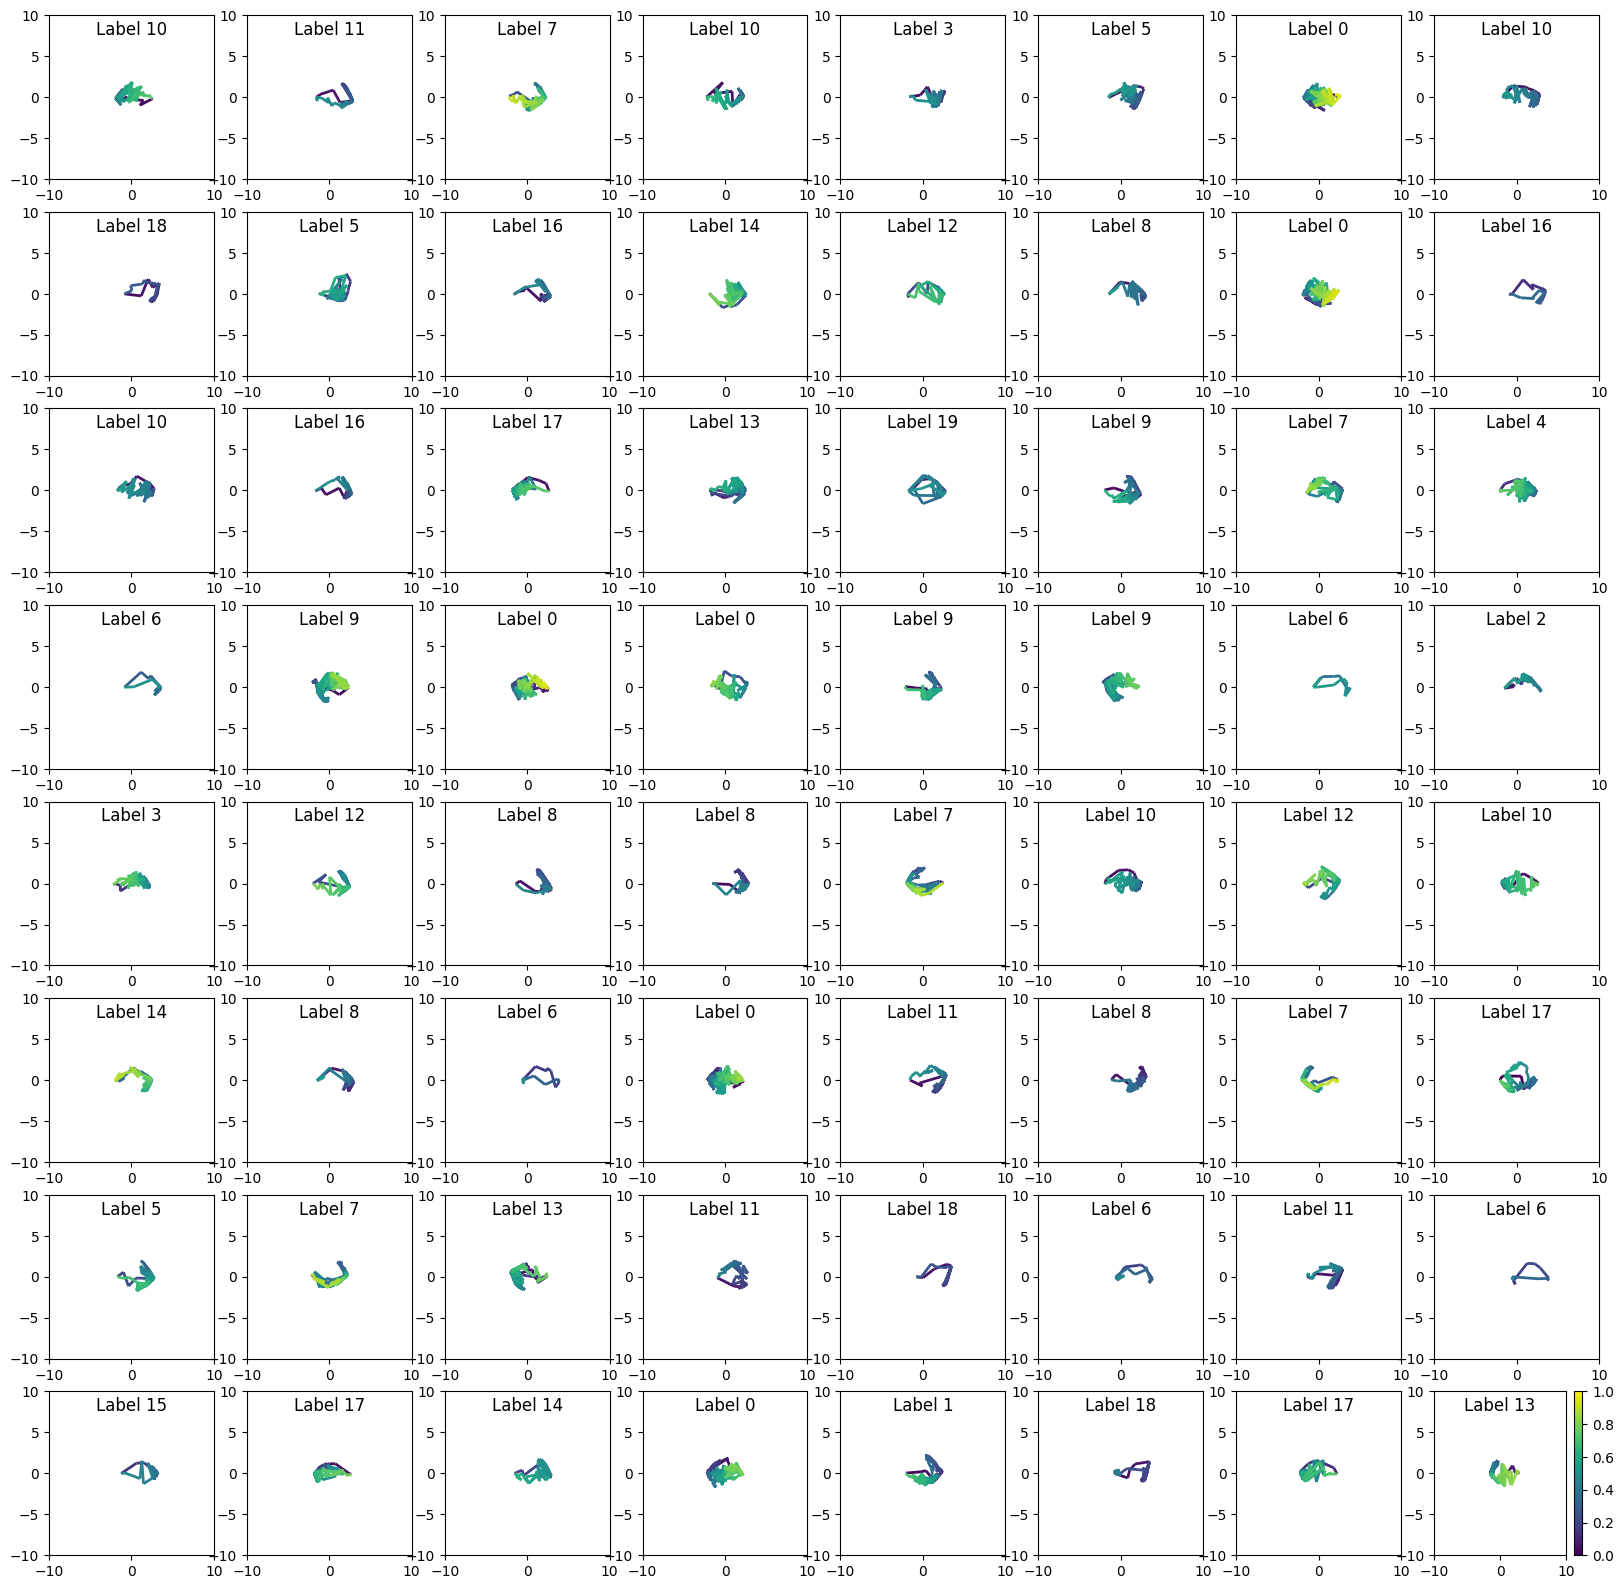

In [74]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

t = np.arange(150)

fig, axs = plt.subplots(8, 8, figsize=(20, 20))
for i in range(64):
    z0 = z[i]
    z0_pca = pca.fit_transform(z0)
    x    = z0_pca[:, 0]
    y    = z0_pca[:, 1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.linspace(0,1,len(x))
    lc = LineCollection(segments, cmap='viridis')
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = axs[i//8, i%8].add_collection(lc)
    # set x and y limits
    axs[i//8, i%8].set_xlim(-10, 10)
    axs[i//8, i%8].set_ylim(-10, 10)
    # add a title with the label
    axs[i//8, i%8].set_title(f'Label {gt_labels_test_batch0[i]}', y=1, pad=-14)
    
fig.colorbar(line,ax=axs[i//8, i%8])

# make the line a gradient of color
# display colorbar
#plt.colorbar()
plt.show()